In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/contradictory-my-dear-watson/sample_submission.csv
/kaggle/input/contradictory-my-dear-watson/train.csv
/kaggle/input/contradictory-my-dear-watson/test.csv


In [2]:

import os

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

import tensorflow_hub as hub


import torch
device = torch.device("cuda")

In [3]:
import numpy as np 
import pandas as pd
data_train = pd.read_csv("/kaggle/input/contradictory-my-dear-watson/train.csv")
data_test = pd.read_csv("/kaggle/input/contradictory-my-dear-watson/test.csv")

In [4]:
data_train['text'] = (data_train['premise'].map(str) +' '+ data_train['hypothesis']).apply(lambda row: row.strip())
data_test['text'] = (data_test['premise'].map(str) +' '+ data_test['hypothesis']).apply(lambda row: row.strip())

In [5]:
print(data_train.columns)
print(data_test.columns)
print(data_train.shape)
print(data_test.shape)

Index(['id', 'premise', 'hypothesis', 'lang_abv', 'language', 'label', 'text'], dtype='object')
Index(['id', 'premise', 'hypothesis', 'lang_abv', 'language', 'text'], dtype='object')
(12120, 7)
(5195, 6)


In [6]:
data_train.label.value_counts()

0    4176
2    4064
1    3880
Name: label, dtype: int64

In [7]:
from transformers import BertTokenizer, TFBertModel, TFAutoModel,AutoTokenizer
module_url = TFAutoModel.from_pretrained('joeddav/xlm-roberta-large-xnli')
bert_layer = hub.KerasLayer(module_url, trainable=True)

Downloading:   0%|          | 0.00/734 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.09G [00:00<?, ?B/s]

2022-02-19 00:49:48.749955: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-19 00:49:48.750965: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-19 00:49:48.751597: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-19 00:49:48.752465: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [8]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("joeddav/xlm-roberta-large-xnli")
def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence) + [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)


Downloading:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.83M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

In [9]:
def build_model(bert_layer, max_len=512):
    input_word_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    embedding = bert_layer([input_word_ids, input_mask, segment_ids])[0]
    clf_output = embedding[:, 0, :]
    net = tf.keras.layers.Dense(64, activation='relu')(clf_output)
    net = tf.keras.layers.Dropout(0.2)(net)
    net = tf.keras.layers.Dense(32, activation='relu')(net)
    net = tf.keras.layers.Dropout(0.2)(net)
    out = tf.keras.layers.Dense(3, activation='softmax')(net)
    
    model = tf.keras.models.Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(tf.keras.optimizers.Adam(lr=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [10]:
from tensorflow import keras
max_len = 150
train_input = bert_encode(data_train.text.values, tokenizer, max_len=max_len)
test_input = bert_encode(data_test.text.values, tokenizer, max_len=max_len)
train_labels = keras.utils.to_categorical(data_train.label.values, num_classes = 3)

In [11]:
model = build_model(bert_layer, max_len=max_len)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 150)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 150)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 150)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        TFBaseModelOutputWit 559890432   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [12]:

earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2, verbose=1, restore_best_weights=True)

train_history = model.fit(
    train_input, train_labels, 
    validation_split=0.2,
    epochs=10,
    callbacks=[earlystopping],
    batch_size=16,
    verbose=1
)

2022-02-19 00:50:20.544550: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
606/606 [==============================] - 636s 1s/step - loss: 0.3850 - accuracy: 0.8627 - val_loss: 0.2646 - val_accuracy: 0.9142


2022-02-19 01:00:58.000231: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1024008192 exceeds 10% of free system memory.
2022-02-19 01:01:00.981067: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1024008192 exceeds 10% of free system memory.


Epoch 2/10
606/606 [==============================] - 613s 1s/step - loss: 0.2411 - accuracy: 0.9191 - val_loss: 0.2824 - val_accuracy: 0.9039
Epoch 3/10
606/606 [==============================] - 613s 1s/step - loss: 0.1682 - accuracy: 0.9512 - val_loss: 0.3967 - val_accuracy: 0.9010
Restoring model weights from the end of the best epoch.
Epoch 00003: early stopping


2022-02-19 01:21:29.399655: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1024008192 exceeds 10% of free system memory.


In [13]:
# Setup plotting
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('animation', html='html5')

# Setup feedback system
from learntools.core import binder
binder.bind(globals())
from learntools.deep_learning_intro.ex6 import *

<AxesSubplot:title={'center':'Cross-entropy'}>

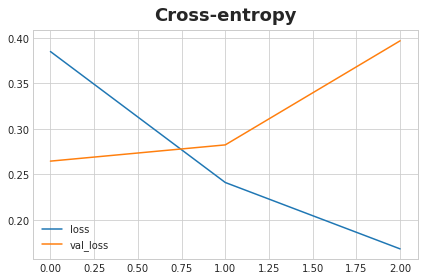

In [28]:
history_df = pd.DataFrame(train_history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
#history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot(title="Accuracy")

In [16]:
preds = model.predict(test_input)

In [17]:
len(preds)

5195

In [18]:
submission = pd.read_csv("../input/contradictory-my-dear-watson/sample_submission.csv")

In [20]:
predictions = [np.argmax(i) for i in preds]

In [22]:
submission.columns

Index(['id', 'prediction'], dtype='object')

In [23]:
submission['prediction'] = predictions

In [27]:
submission.to_csv("submission.csv", index = False)